In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset, info = tfds.load(
    'oxford_iiit_pet:4.0.0',
    with_info=True
)

train_ds = dataset['train']
test_ds = dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.UNYTR1_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.UNYTR1_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = 128

def preprocess(image, mask):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method='nearest')

    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.int32) - 1   # 0: pet, 1: border, 2: background

    return image, mask

In [ ]:
BATCH_SIZE = 16

train_ds = (
    train_ds
    .map(lambda x: preprocess(x['image'], x['segmentation_mask']))
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .map(lambda x: preprocess(x['image'], x['segmentation_mask']))
    .batch(BATCH_SIZE))

In [ ]:
from tensorflow.keras import layers, models

def unet_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)

    # Decoder
    u1 = layers.UpSampling2D()(b)
    concat1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat1)

    u2 = layers.UpSampling2D()(c3)
    concat2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat2)

    outputs = layers.Conv2D(3, 1, activation='softmax')(c4)

    return models.Model(inputs, outputs)

model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │         99 │ conv2d_4[0][0]    │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 231,683 (905.01 KB)

 Trainable params: 231,683 (905.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5)

Epoch 1/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.6055 - loss: 0.8652 - val_accuracy: 0.6952 - val_loss: 0.6885
Epoch 2/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.7063 - loss: 0.6756 - val_accuracy: 0.7342 - val_loss: 0.6367
Epoch 3/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.7371 - loss: 0.6261 - val_accuracy: 0.7476 - val_loss: 0.6089
Epoch 4/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.7557 - loss: 0.5896 - val_accuracy: 0.7679 - val_loss: 0.5660
Epoch 5/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - accuracy: 0.7688 - loss: 0.5609 - val_accuracy: 0.7688 - val_loss: 0.5600


In [ ]:
model.save("pet_segmentation_unet.keras")
print("✅ Model kaydedildi.")

✅ Model kaydedildi.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


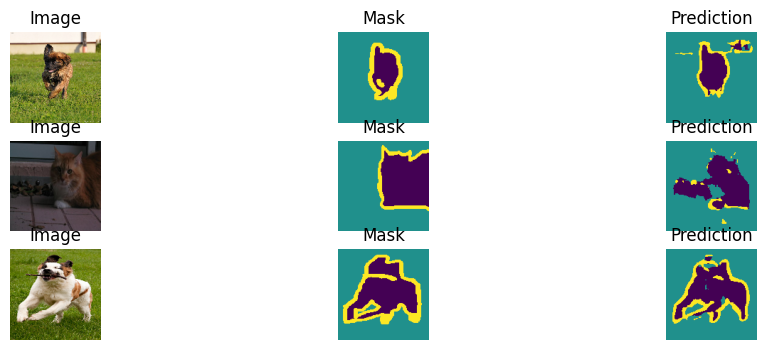

In [ ]:
def display_predictions(dataset):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        preds = tf.argmax(preds, axis=-1)

        plt.figure(figsize=(12,4))
        for i in range(3):
            plt.subplot(3,3,i*3+1)
            plt.imshow(images[i])
            plt.title("Image")
            plt.axis('off')

            plt.subplot(3,3,i*3+2)
            plt.imshow(masks[i])
            plt.title("Mask")
            plt.axis('off')

            plt.subplot(3,3,i*3+3)
            plt.imshow(preds[i])
            plt.title("Prediction")
            plt.axis('off')
        plt.show()

display_predictions(test_ds)